# Anomaly detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import tensorflow as tf
import keras
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from numpy import arange, sin, pi, random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.integrate as integrate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.neighbors._kde import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr

np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

## Read Train and Test Data

In [2]:
def gen_wave():
    """ Generate a synthetic data
    :return: the final data
    """
    t = np.arange(0.0, 100.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.2, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 5.0, 0.01)
    wave3 = -2*sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 500] = wave1[insert:insert + 500] + wave3
    return wave1 - 2*wave2

In [3]:
def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [4]:
def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [5]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x sequence length x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)           
            


In [6]:
def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau

In [7]:
# train on first 7000 samples and test on next 3000 samples (has anomaly)
sequence_length = 11
DATA_SPLIT_PCT = 0.2
SEED = 123 #used to help randomly select the data points
batch_size = 50
epochs = 3
X_train,y_train, X_test, y_test = get_split_prep_data(0, 6999, 7000, 10000)
X_train_X, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
timesteps =  X_train.shape[1] # equal to the sequence_length
n_features =  X_train.shape[2] # 1

wave1 10000
wave2 10000
wave3 500
Length of Data 10000
Creating train data...
Mean of train data :  0.004477792402900583
Train data shape  :  (6988, 11)
Creating test data...
Mean of test data :  0.0005497895275597728
Test data shape  :  (2989, 11)
Shape X_train (6988, 10)
Shape X_test (2989, 10)


In [8]:
%%time
import keras
import tensorflow
from tensorflow.keras.optimizers import Adam, RMSprop

results = {}
for num_cells in [16, 32, 64,80,96]:
    for lr in [1e-4, 1e-3, 1e-2]:
            print('Running with', num_cells, 
                  'LSTM cells', 
                  'and learning rate =', lr, '...')

            # build network
            lstm_autoencoder = Sequential()
            # Encoder
            lstm_autoencoder.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
            lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=False))
            lstm_autoencoder.add(RepeatVector(timesteps))
            # Decoder
            lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=True))
            lstm_autoencoder.add(LSTM(100, activation='relu', return_sequences=True))
            lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
            lstm_autoencoder.summary()
            adam = tensorflow.keras.optimizers.Adam(lr)
            lstm_autoencoder.compile(loss='mse', optimizer=adam)
            cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
            tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
            lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
            print("Predicting...")
            predicted_train = lstm_autoencoder.predict(X_train)
            predicted = lstm_autoencoder.predict(X_test)
            mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)
            mse_train = np.mean(np.power(flatten(X_train) - flatten(predicted_train), 2), axis=1)
            #KDE
            # use grid search cross-validation to optimize the bandwidth
            params = {'bandwidth': np.linspace(0, 0.5, 10)}
            grid = GridSearchCV(KernelDensity(), params, cv = 20)
            grid.fit(mse_train[:, None])
            h=grid.best_estimator_.bandwidth
            tau=FindThreshold(mse_train,h,0.56)
            y_test1=np.ones(X_test.shape[0])
            y_test1[999:1499]=-1
            y_scores=np.ones(X_test.shape[0])
            y_scores[(mse-tau)>0]=-1
            accuracy_kde = accuracy_score(y_test1, y_scores)
            #OCSVM
            e=X_train - predicted_train
            nsamples, nx, ny = e.shape
            d2_e = e.reshape((nsamples,nx*ny))
            from sklearn import svm
            clf = svm.OneClassSVM(nu=0.0055, kernel="rbf", gamma=1.5)
            clf.fit(d2_e)
            e_t=X_test - predicted
            nsamples, nx, ny = e_t.shape
            d2_e_t = e_t.reshape((nsamples,nx*ny))
            y_scores = clf.predict(d2_e_t)
            accuracy_svm = accuracy_score(y_test1, y_scores)
            accuracy= min(accuracy_svm,accuracy_kde)
            results[(num_cells, lr)] = {'accuracy': accuracy}       
val_results = {key: results[key]['accuracy'] for key in results.keys()}+
num_cells, lr = min(val_results, key=val_results.get)
print('Best parameters:', num_cells, 
        'and learning rate =', lr)

#Best parameters: num_cells=64,  lr=0.01
#num_cells=64
#lr = 0.01

Running with 16 LSTM cells and learning rate = 0.0001 ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                12600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 25)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 25)            5100      
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 100)           50400     
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable pa

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 519.61017889 375.85623834 267.87682221 182.03198974
 111.56571711  52.17456358   1.00905468 -43.85548165 -83.76006077]
  warnings.warn(


Running with 16 LSTM cells and learning rate = 0.001 ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 25)                12600     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 25)            5100      
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable p

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 617.61439224 423.90161306 294.16515432 198.1926825
 122.41466796  59.92751507   6.81095283 -39.35766288 -80.17479798]
  warnings.warn(


Running with 16 LSTM cells and learning rate = 0.01 ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 25)                12600     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable pa

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 645.71468951 434.09640603 299.16723069 201.13281332
 124.34188208  61.28524091   7.81774489 -38.58198086 -79.55918552]
  warnings.warn(


Running with 32 LSTM cells and learning rate = 0.0001 ...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_15 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 489.98193476 356.93464873 255.46449192 173.74702491
 105.75077141  47.89697932  -2.25856468 -46.42741875 -85.83388669]
  warnings.warn(


Running with 32 LSTM cells and learning rate = 0.001 ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_17 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable p

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 650.90009706 435.79685786 299.97973399 201.60615057
 124.65076925  61.50227067   7.97839595 -38.45835793 -79.46115923]
  warnings.warn(


Running with 32 LSTM cells and learning rate = 0.01 ...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_21 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_23 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable pa

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 648.90939371 435.18726643 299.69509449 201.4421594
 124.54441491  61.42782511   7.92342331 -38.50059025 -79.49460811]
  warnings.warn(


Running with 64 LSTM cells and learning rate = 0.0001 ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_25 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_27 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 478.08234884 350.99402406 252.97702817 172.53247641
 105.08139493  47.49705719  -2.51217195 -46.59625637 -85.95101917]
  warnings.warn(


Running with 64 LSTM cells and learning rate = 0.001 ...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_29 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_31 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable p

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 645.02517932 433.88493441 299.06765171 201.07720345
 124.30692684  61.26135341   7.80041232 -38.59512695 -79.56949902]
  warnings.warn(


Running with 64 LSTM cells and learning rate = 0.01 ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_33 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_35 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable pa

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 648.93185611 435.23888902 299.73123309 201.46709239
 124.56211802  61.44086582   7.93335992 -38.4927976  -79.48834769]
  warnings.warn(


Running with 80 LSTM cells and learning rate = 0.0001 ...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_37 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 10, 25)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_39 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 469.09052854 338.13472477 241.58651251 163.98590304
  98.75457146  42.6951246   -6.25548047 -49.58351093 -88.38321976]
  warnings.warn(


Running with 80 LSTM cells and learning rate = 0.001 ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_41 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 10, 25)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_43 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 636.83927554 431.09457735 297.72077722 200.29067837
 123.79342736  60.90056584   7.53338077 -38.80058418 -79.73239687]
  warnings.warn(


Running with 80 LSTM cells and learning rate = 0.01 ...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_45 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 10, 25)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_47 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable p

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 639.04069352 431.97848143 298.1699889  200.5610748
 123.97311679  61.02819096   7.62850236 -38.72704993 -79.6739004 ]
  warnings.warn(


Running with 96 LSTM cells and learning rate = 0.0001 ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_49 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 10, 25)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_51 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 502.13749661 369.65934334 265.13067964 180.52994296
 110.63789626  51.54700089   0.55568397 -44.19904542 -84.02983643]
  warnings.warn(


Running with 96 LSTM cells and learning rate = 0.001 ...
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_53 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 10, 25)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_55 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 593.42522705 414.50534709 289.47977187 195.42780634
 120.60130943  58.65040929   5.86440689 -40.08659006 -80.75307642]
  warnings.warn(


Running with 96 LSTM cells and learning rate = 0.01 ...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 10, 100)           40800     
_________________________________________________________________
lstm_57 (LSTM)               (None, 25)                12600     
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 10, 25)            0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 10, 25)            5100      
_________________________________________________________________
lstm_59 (LSTM)               (None, 10, 100)           50400     
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 1)             101       
Total params: 109,001
Trainable params: 109,001
Non-trainable p

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 652.78467526 436.37006168 300.24590262 201.75798532
 124.74851586  61.57035139   8.02849907 -38.41995719 -79.43079653]
  warnings.warn(


Best parameters: 80 and learning rate = 0.0001
Wall time: 21min 33s


## Generate Labels for Train Data

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 10, 320)           412160    
_________________________________________________________________
lstm_61 (LSTM)               (None, 80)                128320    
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 10, 80)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 10, 80)            51520     
_________________________________________________________________
lstm_63 (LSTM)               (None, 10, 320)           513280    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 10, 1)             321       
Total params: 1,105,601
Trainable params: 1,105,601
Non-trainable params: 0
___________________________________________

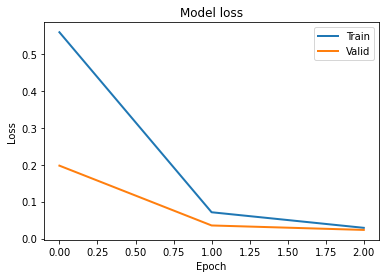

Wall time: 1min 13s


In [9]:
%%time
import keras
import tensorflow
from tensorflow.keras.optimizers import Adam, RMSprop

lstm_autoencoder = Sequential()

# Encoder
lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(num_cells, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(num_cells*4, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

adam = tensorflow.keras.optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)


lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
                                                
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


## Normalize Train and Test Data

Predicting...


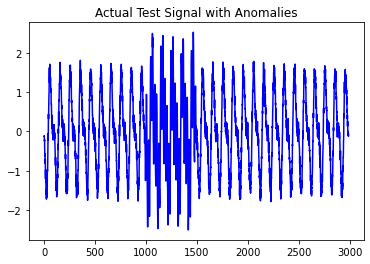

Wall time: 18.2 s


In [10]:
%%time
print("Predicting...")
predicted_train = lstm_autoencoder.predict(X_train)
predicted = lstm_autoencoder.predict(X_test)
#print("Reshaping predicted")
#predicted_train = np.reshape(predicted_train, (predicted_train.size,))
#predicted = np.reshape(predicted, (predicted.size,))





plt.figure()
plt.title("Actual Test Signal w/Anomalies")
plt.plot(y_train[:len(y_train)], 'b')




plt.figure()
plt.title("Squared Error")
mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)
plt.plot(mse, 'r')
mse_train = np.mean(np.power(flatten(X_train) - flatten(predicted_train), 2), axis=1)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Actual Test Signal with Anomalies")
plt.plot(y_test[:len(y_test)], 'b')
plt.savefig('Epoch.png', dpi=1200)
plt.show()

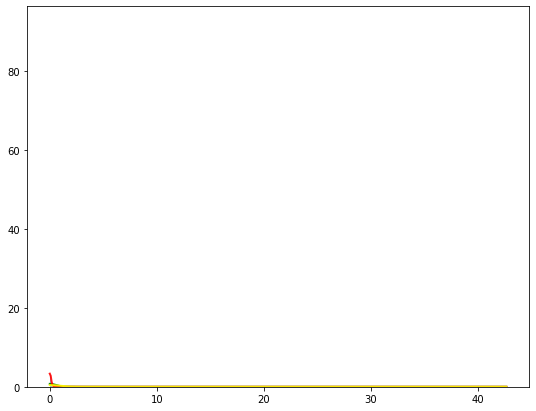

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 607.56896706 419.87132474 292.14476246 197.00158099
 121.63661624  59.38175717   6.40779463 -39.66733019 -80.41997582]
  warnings.warn(


best bandwidth: 0.05555555555555555
Tau :  0.11278381197247303
Precision :  0.9534428794992176
Recall:  0.9791080755323424
Accuracy :  0.942790230846437
F1_score:  0.891412655872071


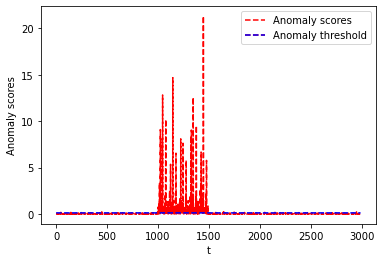

In [11]:
#KDE
def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau

#Plot histogram
fig, ax2 = plt.subplots(figsize = (9,7))
ax2.hist(mse_train, bins = 100, alpha = 0.5, density = True)

#Plot KDE
pdf, mse_grid = kde_sklearn(mse, bandwidth = 0.5)
pdf2, mse_grid2 = kde_sklearn(mse, bandwidth = 0.1)
pdf3, mse_grid3 = kde_sklearn(mse, bandwidth = 0.9)
ax2.plot(mse_grid, pdf, alpha = 0.9, color = 'green', linewidth = 2.0)
ax2.plot(mse_grid2, pdf2, alpha = 0.9, color = 'red', linewidth = 2.0)
ax2.plot(mse_grid3, pdf3, alpha = 0.9, color = 'yellow', linewidth = 2.0)
plt.show()

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.linspace(0, 0.5, 10)}
grid = GridSearchCV(KernelDensity(), params, cv = 20)
grid.fit(mse_train[:, None])

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
h=grid.best_estimator_.bandwidth
tau=FindThreshold(mse_train,h,0.56)

y_test1=np.ones(X_test.shape[0])
y_test1[999:1499]=-1
y_scores=np.ones(X_test.shape[0])
y_scores[(mse-tau)>0]=-1
precision = precision_score(y_test1, y_scores)
recall    = recall_score(y_test1, y_scores)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, average='macro')
print ('Tau : ', tau)
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('Accuracy : ', accuracy)
print ('F1_score: ', f1)
fig=plt.figure(4)
red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
plt.xlabel('t')
plt.ylabel('Anomaly scores')
plt.legend([red_dot, (red_dot, white_cross)], ["Anomaly scores", "Anomaly threshold"])
plt.show()
fig.savefig('plot.png', dpi=1200)  




OCSVM

In [12]:
%%time
#OCSVM
e=X_train - predicted_train
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples,nx*ny))

from sklearn import svm
clf = svm.OneClassSVM(nu=0.0055, kernel="rbf", gamma=1.5)
clf.fit(d2_e)

e_t=X_test - predicted
nsamples, nx, ny = e_t.shape
d2_e_t = e_t.reshape((nsamples,nx*ny))
y_scores = clf.predict(d2_e_t)
precision = precision_score(y_test1, y_scores)
recall    = recall_score(y_test1, y_scores)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, average='macro')
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('Accuracy : ', accuracy)
print ('F1_score: ', f1)


Precision :  0.9872
Recall:  0.991562876657292
Accuracy :  0.9822683171629307
F1_score:  0.9678935721276394
Wall time: 136 ms


Loading data... 
wave1 10000
wave2 10000
wave3 500
Length of Data 10000
Creating train data...
Mean of train data :  -0.0023143809349431264
Train data shape  :  (6988, 11)
Creating test data...
Mean of test data :  -0.0011886460694082693
Test data shape  :  (2989, 11)
Shape X_train (6988, 10)
Shape X_test (2989, 10)

Data Loaded. Compiling...

Compilation Time :  0.007991552352905273
Training...
Epoch 1/3
133/133 [==============================] - 19s 82ms/step - loss: 0.1507 - val_loss: 0.0514
Epoch 2/3
133/133 [==============================] - 9s 71ms/step - loss: 0.0515 - val_loss: 0.0347
Epoch 3/3
133/133 [==============================] - 10s 76ms/step - loss: 0.0462 - val_loss: 0.0380
Predicting...
Reshaping predicted


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan 536.61543798 388.38501187 275.68058064 187.08074373
 115.0498901   54.70582683   2.92326557 -42.36108807 -82.56301969]
  warnings.warn(


best bandwidth: 0.05555555555555555


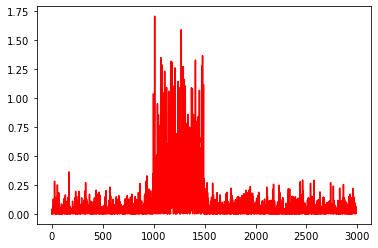

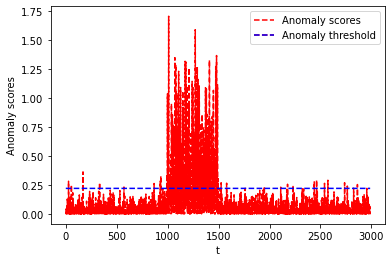

Tau :  0.22061267156010883
Precision :  0.9227886056971514
Recall:  0.9891522699879469
Accuracy :  0.9220475075276012
F1_score:  0.8355092247166145


(<keras.engine.sequential.Sequential at 0x1930caaedc0>,
 array([-0.11626825, -0.0808487 , -0.39837722, ..., -0.08395971,
        -0.14677785, -0.09585726]),
 array([-0.12957723, -0.17284414, -0.19141081, ..., -0.05771049,
        -0.11410607, -0.18683001], dtype=float32),
 array([ 1.48499645, -1.57696811,  1.22734993, ...,  1.41472294,
         1.05774595, -1.39478149]),
 array([ 1.6489896, -1.6260813,  1.6327689, ...,  1.3198444,  1.1849064,
        -1.6977444], dtype=float32))

In [13]:
#Tran et al., 2019

def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            units=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            units=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

#KDE
def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau
  
def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print ('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train,y_train, X_test, y_test = get_split_prep_data(0, 6999, 7000, 10000)
    else:
        X_train, y_train, X_test, y_test = data

    print ('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted_train = model.predict(X_train)
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted_train = np.reshape(predicted_train, (predicted_train.size,))
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, y_train, 0

    try:
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        mse_train = ((y_train - predicted_train) ** 2)
        # use grid search cross-validation to optimize the bandwidth
        params = {'bandwidth': np.linspace(0, 0.5, 10)}
        grid = GridSearchCV(KernelDensity(), params, cv = 20)
        grid.fit(mse_train[:, None])
        print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
        h=grid.best_estimator_.bandwidth
        tau=FindThreshold(mse_train,h,0.56)
        #tau=max(mse_train)
        y_test1=np.ones(len(y_test))
        y_test1[999:1499]=-1
        y_scores=np.ones(len(y_test))
        y_scores[(mse-tau)>0]=-1
        
        precision = precision_score(y_test1, y_scores)
        recall    = recall_score(y_test1, y_scores)
        accuracy = accuracy_score(y_test1, y_scores)
        f1 = f1_score(y_test1, y_scores, average='macro') 
     
        fig=plt.figure(3)
        red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
        plt.xlabel('t')
        plt.ylabel('Anomaly scores')
        plt.legend([red_dot, (red_dot, white_cross)], ["Anomaly scores", "Anomaly threshold"])
        plt.show()
        fig.savefig('plot.png', dpi=1200)
        print ('Tau : ', tau)
        print ('Precision : ', precision)
        print ('Recall: ', recall)
        print ('Accuracy : ', accuracy)
        print ('F1_score: ', f1)
        
    except Exception as e:
        print("plotting exception")
        print (str(e))
        print ('Training duration (s) : ', time.time() - global_start_time)

    
    
    return model, y_test, predicted, y_train, predicted_train

run_network()